In [1]:
%matplotlib inline


# Trialwise Decoding on BCIC IV 2a Dataset

This tutorial shows you how to train and test deep learning models with
Braindecode in a classical EEG setting: you have trials of data with
labels (e.g., Right Hand, Left Hand, etc.).


## Loading and preprocessing the dataset




### Loading




First, we load the data. In this tutorial, we use the functionality of
braindecode to load datasets through
`MOABB <https://github.com/NeuroTechX/moabb>`__ to load the BCI
Competition IV 2a data.

<div class="alert alert-info"><h4>Note</h4><p>To load your own datasets either via mne or from
   preprocessed X/y numpy arrays, see `MNE Dataset
   Tutorial <./plot_mne_dataset_example.html>`__ and `Numpy Dataset
   Tutorial <./plot_custom_dataset_example.html>`__.</p></div>




In [2]:
from braindecode.datasets import MOABBDataset

subject_id = 3
dataset = MOABBDataset(dataset_name="BNCI2014001", subject_ids=[subject_id])

48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]
48 events found
Event IDs: [1 2 3 4]


### Preprocessing




Now we apply preprocessing like bandpass filtering to our dataset. You
can either apply functions provided by
`mne.Raw <https://mne.tools/stable/generated/mne.io.Raw.html>`__ or
`mne.Epochs <https://mne.tools/0.11/generated/mne.Epochs.html#mne.Epochs>`__
or apply your own functions, either to the MNE object or the underlying
numpy array.

<div class="alert alert-info"><h4>Note</h4><p>These prepocessings are now directly applied to the loaded
   data, and not on-the-fly applied as transformations in
   PyTorch-libraries like
   `torchvision <https://pytorch.org/docs/stable/torchvision/index.html>`__.</p></div>




In [3]:
from braindecode.preprocessing import (
    exponential_moving_standardize, preprocess, Preprocessor, scale)

low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000

preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
    Preprocessor(scale, factor=1e6, apply_on_array=True),  # Convert from V to uV
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
    Preprocessor(exponential_moving_standardize,  # Exponential moving standardization
                 factor_new=factor_new, init_block_size=init_block_size)
]

# Transform the data
preprocess(dataset, preprocessors)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)



C:\Users\Yannick\Miniconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function scale is deprecated; will be removed in 0.7.0. Use numpy.multiply instead.
  warnings.warn(msg, category=FutureWarning)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 38.00 Hz
- Upper transition bandwidth: 9.50 Hz (-6 dB cutoff frequency: 42.75 Hz)
- Filter length: 413 samples (1.652 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 38 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 

### Cut Compute Windows




Now we cut out compute windows, the inputs for the deep networks during
training. In the case of trialwise decoding, we just have to decide if
we want to cut out some part before and/or after the trial. For this
dataset, in our work, it often was beneficial to also cut out 500 ms
before the trial.




In [4]:
from braindecode.preprocessing import create_windows_from_events

trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 48 events and 1125 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Adding metadata with 4 columns
48 matching even

### Split dataset into train and valid




We can easily split the dataset using additional info stored in the
description attribute, in this case ``session`` column. We select
``session_T`` for training and ``session_E`` for validation.




In [5]:
splitted = windows_dataset.split('session')
train_set = splitted['session_T']
valid_set = splitted['session_E']

## Create model




Now we create the deep learning model! Braindecode comes with some
predefined convolutional neural network architectures for raw
time-domain EEG. Here, we use the shallow ConvNet model from `Deep
learning with convolutional neural networks for EEG decoding and
visualization <https://arxiv.org/abs/1703.05051>`__. These models are
pure `PyTorch <https://pytorch.org>`__ deep learning models, therefore
to use your own model, it just has to be a normal PyTorch
`nn.Module <https://pytorch.org/docs/stable/nn.html#torch.nn.Module>`__.




In [6]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True
# Set random seed to be able to roughly reproduce results
# Note that with cudnn benchmark set to True, GPU indeterminism
# may still make results substantially different between runs.
# To obtain more consistent results at the cost of increased computation time,
# you can set `cudnn_benchmark=False` in `set_random_seeds`
# or remove `torch.backends.cudnn.benchmark = True`
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
# Extract number of chans and time steps from dataset
n_chans = train_set[0][0].shape[0]
input_window_samples = train_set[0][0].shape[1]

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

# Send model to GPU
if cuda:
    model.cuda()

In [7]:
print(n_chans, n_classes, input_window_samples)

22 4 1125


## Training




Now we train the network! EEGClassifier is a Braindecode object
responsible for managing the training of neural networks. It inherits
from skorch.NeuralNetClassifier, so the training logic is the same as in
`Skorch <https://skorch.readthedocs.io/en/stable/>`__.




**Note**: In this tutorial, we use some default parameters that we
have found to work well for motor decoding, however we strongly
encourage you to perform your own hyperparameter optimization using
cross validation on your training data.




In [20]:
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGClassifier
# These values we found good for shallow network:
lr = 0.0625 * 0.01
weight_decay = 0

# For deep4 they should be:
# lr = 1 * 0.01
# weight_decay = 0.5 * 0.001

batch_size = 64
n_epochs = 4

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    #train_split=predefined_split(valid_set),  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
# Model training for a specified number of epochs. `y` is None as it is already supplied
# in the dataset.
clf.fit(train_set, y=train_set.get_metadata()['target'], epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.2609        1.0514            0.2414        3.5075  0.0006  3.2437
      2            0.2609        0.9817            0.2414        2.9034  0.0005  3.2549
      3            0.2783        0.8484            0.2931        2.2398  0.0002  3.1865
      4            0.3174        0.7815            0.3448        1.6714  0.0000  3.1842


<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=ShallowFBCSPNet(
    (ensuredims): Ensure4d()
    (dimshuffle): Expression(expression=transpose_time_to_spat) 
    (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
    (conv_spat): Conv2d(40, 40, kernel_size=(1, 22), stride=(1, 1), bias=False)
    (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_nonlin_exp): Expression(expression=square) 
    (pool): AvgPool2d(kernel_size=(75, 1), stride=(15, 1), padding=0)
    (pool_nonlin_exp): Expression(expression=safe_log) 
    (drop): Dropout(p=0.5, inplace=False)
    (conv_classifier): Conv2d(40, 4, kernel_size=(69, 1), stride=(1, 1))
    (softmax): LogSoftmax(dim=1)
    (squeeze): Expression(expression=squeeze_final_output) 
  ),
)

In [10]:
train_set.get_metadata()['target']

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,subject,session,run
0,0,625,1750,1,3,session_T,run_0
1,0,2628,3753,2,3,session_T,run_0
2,0,4546,5671,2,3,session_T,run_0
3,0,6498,7623,1,3,session_T,run_0
4,0,8506,9631,2,3,session_T,run_0
...,...,...,...,...,...,...,...
43,0,87125,88250,0,3,session_T,run_5
44,0,89031,90156,3,3,session_T,run_5
45,0,90959,92084,0,3,session_T,run_5
46,0,93073,94198,1,3,session_T,run_5


In [30]:
len(train_set.datasets[3].y)

48

In [18]:
valid_set.get_metadata()

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,subject,session,run
0,0,625,1750,1,3,session_E,run_0
1,0,2628,3753,2,3,session_E,run_0
2,0,4546,5671,2,3,session_E,run_0
3,0,6498,7623,1,3,session_E,run_0
4,0,8506,9631,2,3,session_E,run_0
...,...,...,...,...,...,...,...
43,0,87125,88250,0,3,session_E,run_5
44,0,89031,90156,3,3,session_E,run_5
45,0,90959,92084,0,3,session_E,run_5
46,0,93073,94198,1,3,session_E,run_5


## Plot Results




Now we use the history stored by Skorch throughout training to plot
accuracy and loss curves.




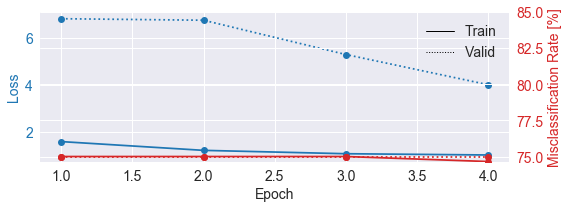

In [8]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

# Extract loss and accuracy values for plotting from history object
results_columns = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy']
df = pd.DataFrame(clf.history[:, results_columns], columns=results_columns,
                  index=clf.history[:, 'epoch'])

# get percent of misclass for better visual comparison to loss
df = df.assign(train_misclass=100 - 100 * df.train_accuracy,
               valid_misclass=100 - 100 * df.valid_accuracy)

plt.style.use('seaborn')
fig, ax1 = plt.subplots(figsize=(8, 3))
df.loc[:, ['train_loss', 'valid_loss']].plot(
    ax=ax1, style=['-', ':'], marker='o', color='tab:blue', legend=False, fontsize=14)

ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=14)
ax1.set_ylabel("Loss", color='tab:blue', fontsize=14)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

df.loc[:, ['train_misclass', 'valid_misclass']].plot(
    ax=ax2, style=['-', ':'], marker='o', color='tab:red', legend=False)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=14)
ax2.set_ylabel("Misclassification Rate [%]", color='tab:red', fontsize=14)
ax2.set_ylim(ax2.get_ylim()[0], 85)  # make some room for legend
ax1.set_xlabel("Epoch", fontsize=14)

# where some data has already been plotted to ax
handles = []
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle='-', label='Train'))
handles.append(Line2D([0], [0], color='black', linewidth=1, linestyle=':', label='Valid'))
plt.legend(handles, [h.get_label() for h in handles], fontsize=14)
plt.tight_layout()

## Plot Confusion Matrix




Generate a confusion matrix as in https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.23730




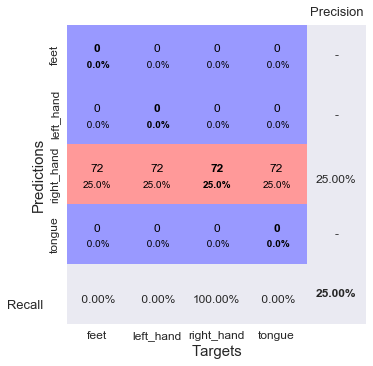

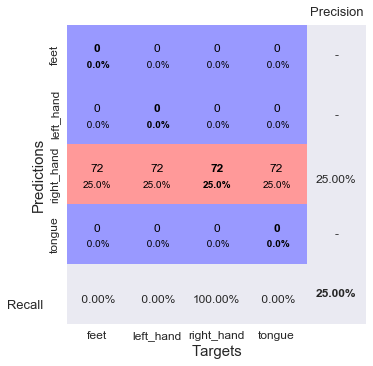

In [9]:
from sklearn.metrics import confusion_matrix
from braindecode.visualization import plot_confusion_matrix

# generate confusion matrices
# get the targets
y_true = valid_set.get_metadata().target
y_pred = clf.predict(valid_set)

# generating confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

# add class labels
# label_dict is class_name : str -> i_class : int
label_dict = valid_set.datasets[0].windows.event_id.items()
# sort the labels by values (values are integer class labels)
labels = list(dict(sorted(list(label_dict), key=lambda kv: kv[1])).keys())

# plot the basic conf. matrix
plot_confusion_matrix(confusion_mat, class_names=labels)

In [14]:
windows_dataset.description

,subject,session,run
0,3,session_T,run_0
1,3,session_T,run_1
2,3,session_T,run_2
3,3,session_T,run_3
4,3,session_T,run_4
5,3,session_T,run_5
6,3,session_E,run_0
7,3,session_E,run_1
8,3,session_E,run_2
9,3,session_E,run_3
